# Download and store images

Create dataset by assembling and resizing images

## Config

In [1]:
import pandas as pd
import numpy as np
from simple_image_download import simple_image_download as simp
import shutil
from glob import glob
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from typing import Tuple, Dict
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import gbif_dl

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

In [3]:
n_positive_examples = 2500
n_negative_examples = 2500

positive_terms = ["poison ivy plant"]

default_download_path = Path("simple_images")
store_path = Path("../datasets/pipeline_v1/downloaded_images")
metadata_loc = Path("../datasets/pipeline_v1/downloaded_images/image_metadata.csv")

similar_plants = [
    "Box elder",
    "Virgin's bower",
    "Virginia creeper",
    "Western poison oak",
    "Poison sumac",
    "Kudzu",
    "Blackberries",
    "Strawberries",
    "Fragrant sumac",
    "Hoptree",
] # Source: "https://en.wikipedia.org/wiki/Toxicodendron_radicans"
negative_terms = [f"{plant} plant" for plant in similar_plants]


PLANTNET_KEY = "7a3679ef-5582-4aaa-81f0-8c2545cafc81"
plantnet_dl_target_path = Path("../datasets/pipeline_v1/plantnet_raw")
n_plantnet_examples = 2000

In [20]:
def resize_by_min_dim(size: Tuple[int, int], min_dim:int =100) -> Tuple[int, int]:
    """
    Resize an image to keep the same proportions and make the smaller
    of the two dimensions equal to min_dim
    size = (width, height) in pixels
    returns (new_width, new_height)
    """
    width, height = size
    if (width <= min_dim) or (height <= min_dim):  # No need to resize images which are already small enough
        return size
    new_height = new_width = None
    if width > height:
        new_height = min_dim
        new_width = int((width/height) * new_height)
    else:
        new_width = min_dim
        new_height = int((height/width) * new_width)
    return (new_width, new_height)
    

def download_images(search_term: str, count: int = 5):
    """
    Downloads images based on search terms to simple_images folder
    """
    # Clear download space so we only keep downloaded images
    src_folder = Path("simple_images")  # default property of simple_image_download package
    if src_folder.exists():
        shutil.rmtree(str(src_folder))
    downloader = simp.simple_image_download()
    logging.info(f"Starting download for: {search_term} x {count}")
    downloader.download(search_term, count)
    logging.info(f"Downloaded images for: {search_term} x {count}")
        
    
    

In [21]:
def gather_and_store_image_script(search_term_counts: Dict[str, int],
                                  dest_dir: str,
                                  img_min_dimen: int = 500,
                                  clean_dest_dir: bool = False) -> pd.DataFrame:
    """
    Downloads google image based on a dict of search terms: count of images to download
    Downsizes image if they are too large by putting smaller dimension to min_dimen and keeping aspect ratio
    If clean_dest_dir, remove all data from destination first
    Returns a dataframe of the results
    """
    dest_path = Path(dest_dir)
    if dest_path.exists() and (clean_dest_dir == True):
      shutil.rmtree(dest_path)
      dest_path.mkdir(parents=True, exist_ok=True)
    if not dest_path.exists():
      dest_path.mkdir(parents=True, exist_ok=True)
    
    download_dir = Path("simple_images")
    image_metadata = []
    img_data = {}
    
    
    for search_term, count in search_term_counts.items():
      download_images(search_term, count)
      for img_loc in glob(str(Path(download_dir, search_term, '*'))):
        img_path = Path(img_loc)
        file_name = img_path.name.replace(" ", "_")
        dest_loc = Path(dest_path, file_name)
        
        img_data = {
          "download_loc": str(img_path),
          "final_loc": str(dest_loc),
          "full_path": str(dest_loc.absolute().resolve()),
          "search_term": search_term,
          "source": "Google Images",
          "file_name": file_name
        }
        
        try:
          img = Image.open(img_path).convert('RGB')
          img_data['read'] = True
        except UnidentifiedImageError:
          img_data['read'] = False
        
        if img_data['read']:
          img_data['orig_width'], img_data['orig_height'] = img.size
          img_data['width'], img_data['height'] = resize_by_min_dim((img_data['orig_width'],
                                                                     img_data['orig_height']), min_dim=500)
          resized_img = img.resize((img_data['width'], img_data['height']), Image.ANTIALIAS)
          resized_img.save(img_data['final_loc'], 'JPEG', quality=90)
        
        image_metadata.append(img_data)
    if download_dir.exists():
      shutil.rmtree(str(download_dir))

    return(pd.DataFrame(image_metadata).set_index("file_name"))
    

In [55]:
%%time
# Positive images
n_positive_each = int(n_positive_examples / len(positive_terms))
df_pos = gather_and_store_image_script({pos_term: n_positive_each
                                        for pos_term in positive_terms},
                                       str(Path(store_path, 'positive')))
df_pos['label'] = 1
df_pos['label_str'] = 'positive'

INFO:root:Downloaded all images
INFO:root:Starting download for: poison ivy plant x 2500


HTTPSConnectionPool(host='naturework.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/06/Poison_Ivy-Early-May_coloring.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3a41d86be0>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='naturework.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/06/Poison_Ivy-Early-May_coloring.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3a41ce59b0>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='naturework.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/06/Poison_Ivy-Early-May_coloring.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3a41ce7f98>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='naturework.com', port=443): Max 

INFO:root:Downloaded images for: poison ivy plant x 2500
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [59]:
%%time
# Negative images
n_negative_each = int(n_negative_examples / len(negative_terms))
df_neg = gather_and_store_image_script({neg_term: n_negative_each
                                        for neg_term in negative_terms},
                                       str(Path(store_path, 'negative')),
                                       clean_dest_dir=False)
df_neg['label'] = 0
df_neg['label_str'] = 'negative'

INFO:root:Starting download for: Box elder plant x 250
INFO:root:Downloaded images for: Box elder plant x 250
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
INFO:root:Starting download for: Virgin's bower plant x 250
INFO:root:Downloaded images for: Virgin's bower plant x 250
INFO:root:Starting download for: Virginia creeper plant x 250


('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))


INFO:root:Downloaded images for: Virginia creeper plant x 250
INFO:root:Starting download for: Western poison oak plant x 250


HTTPSConnectionPool(host='cleverhomestead.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/12/poison-ivy-eastern-western-toxicodendron-radicans-rydbergii-featured-1280x640.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3a4cfe1a58>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))


INFO:root:Downloaded images for: Western poison oak plant x 250
INFO:root:Starting download for: Poison sumac plant x 250
INFO:root:Downloaded images for: Poison sumac plant x 250
INFO:root:Starting download for: Kudzu plant x 250


('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))


INFO:root:Downloaded images for: Kudzu plant x 250
INFO:root:Starting download for: Blackberries plant x 250
INFO:root:Downloaded images for: Blackberries plant x 250
INFO:root:Starting download for: Strawberries plant x 250
INFO:root:Downloaded images for: Strawberries plant x 250
INFO:root:Starting download for: Fragrant sumac plant x 250


HTTPSConnectionPool(host='64.209.142.95', port=443): Max retries exceeded with url: /images/products/rhus_lacette.jpg (Caused by SSLError(CertificateError("hostname '64.209.142.95' doesn't match either of 'www.estabrooksonline.com', 'estabrooksonline.com'",),))


HTTPSConnectionPool(host='64.209.142.95', port=443): Max retries exceeded with url: /images/products/rhus_lacette.jpg (Caused by SSLError(CertificateError("hostname '64.209.142.95' doesn't match either of 'www.estabrooksonline.com', 'estabrooksonline.com'",),))


HTTPSConnectionPool(host='64.209.142.95', port=443): Max retries exceeded with url: /images/products/rhus_lacette.jpg (Caused by SSLError(CertificateError("hostname '64.209.142.95' doesn't match either of 'www.estabrooksonline.com', 'estabrooksonline.com'",),))


INFO:root:Downloaded images for: Fragrant sumac plant x 250
INFO:root:Starting download for: Hoptree plant x 250


HTTPSConnectionPool(host='centraldata.gardenconnect.com', port=443): Max retries exceeded with url: /files/images/plantguide/plant_3011dda0aa_n.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3a4cf38cf8>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='centraldata.gardenconnect.com', port=443): Max retries exceeded with url: /files/images/plantguide/plant_3011dda0aa_n.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3a4cee1748>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='centraldata.gardenconnect.com', port=443): Max retries exceeded with url: /files/images/plantguide/plant_3011dda0aa_n.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3a4cf385c0>: Failed to establish a new connection: [Errno 111] Connection refused',))


INFO:root:Downloaded images for: Hoptree plant x 250


## Supplement with ImageNet and PlantNet data 

### Plantnet Data

In [25]:

def gather_and_store_plantnet_images(dest_dir: str, download_dir: str,
                                     nb_samples: int =5, min_dim: int = 5) -> pd.DataFrame:
    """
    Downloads images via gbif_dl from Plantnet database
    Resizes and moves to dest_dir for final storage
    """
    # Download images based on query
    query = {
        "datasetKey": [
            PLANTNET_KEY,
        ]
    }
    data_generator = gbif_dl.api.generate_urls(
        queries=query,
        label="speciesKey",
        nb_samples=nb_samples)
    gbif_dl.io.download(data_generator, root=download_dir)
    logging.info("Downloaded images")

    # Move + resize images, store metadata    
    image_metadata = []
    dest_path = Path(dest_dir)
    for n_iter, img_loc in enumerate(glob(str(Path(plantnet_dl_target_path, '**', '*')))):
        img_path = Path(img_loc)
        species_code = img_path.parents[0].name
        file_name = f"Plantnet_image-{n_iter+1}_species-{species_code}.jpg"
        download_name = img_path.name
        dest_loc = Path(dest_path, file_name)
            
        img_data = {
            "download_loc": str(img_path),
            "final_loc": str(dest_loc),
            "full_path": str(dest_loc.absolute().resolve()),
            "search_term": species_code,
            "source": "Plantnet",
            "file_name": file_name,
            "download_name": download_name
        }
            
        try:
            img = Image.open(img_path).convert('RGB')
            img_data['read'] = True
        except UnidentifiedImageError:
            img_data['read'] = False
        
        if img_data['read']:
            img_data['orig_width'], img_data['orig_height'] = img.size
            img_data['width'], img_data['height'] = resize_by_min_dim((img_data['orig_width'],
                                                                        img_data['orig_height']), min_dim=min_dim)
            resized_img = img.resize((img_data['width'], img_data['height']), Image.ANTIALIAS)
            resized_img.save(img_data['final_loc'], 'JPEG', quality=90)
        
        image_metadata.append(img_data)
    return(pd.DataFrame(image_metadata).set_index("file_name"))


In [26]:
%%time
df_PN = gather_and_store_plantnet_images(dest_dir=str(Path(store_path, 'negative')),
                                         download_dir=str(plantnet_dl_target_path),
                                         nb_samples=n_plantnet_examples)
df_PN['label'] = 0
df_PN['label_str'] = 'negative'

2000


2000 Files [00:29, 68.50 Files/s]
INFO:Downloaded images


## Imagenet

Imagenet images were downloaded directly from: https://www.kaggle.com/ifigotin/imagenetmini-1000

In [ ]:
#TODO

'3001956'

## Analyze and store metadata

In [63]:
df_ims = pd.concat([df_pos, df_neg, df_PN])
df_ims.head()

,download_loc,final_loc,full_path,search_term,source,read,orig_width,orig_height,width,height,label,label_str
file_name,,,,,,,,,,,,
poison_ivy_plant_1.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,120.0,44.0,120.0,44.0,1,positive
poison_ivy_plant_10.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,800.0,450.0,800.0,450.0,1,positive
poison_ivy_plant_100.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,4250.0,2833.0,750.0,500.0,1,positive
poison_ivy_plant_1000.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,722.0,406.0,722.0,406.0,1,positive
poison_ivy_plant_1001.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1280.0,720.0,888.0,500.0,1,positive


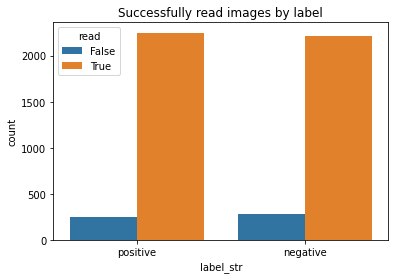

In [66]:
sns.countplot(data=df_ims, x='label_str', hue='read')
plt.title("Successfully read images by label")
plt.show()

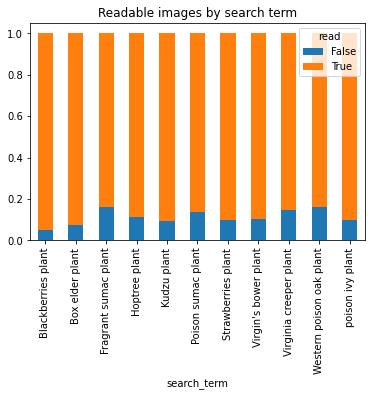

In [91]:
term_counts = df_ims['search_term'].value_counts()
df_plot = df_ims.groupby(['search_term', 'read'])[['label_str']] \
    .count() \
    .rename({'label_str': 'count'}, axis=1) \
    .reset_index()
    
df_plot['frac'] = df_plot.apply(lambda row: row['count'] / term_counts[row['search_term']], axis=1)
# df_plot.set_index('read').unstack()
df_plot = df_plot.set_index(['search_term', 'read']).unstack()
df_plot.plot.bar(y='frac', stacked=True, title='Readable images by search term')
plt.show()
# sns.barplot(data=df_plot, x='search_term', y='frac', hue='read', dodge=False, s)

In [94]:
df_ims.to_csv(metadata_loc)